# Batik Classification

## 1. Exploratory Data Analysis

In [22]:
import os

In [23]:
train_data_dir = 'data/train/'
test_data_dir = 'data/test/'

In [24]:
# Iterate and count labels from dataset
def dataset_label_count(data_dir):
    label_counts = {}
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            count = len([file for file in os.listdir(label_path) if file.endswith('.jpg')])
            label_counts[label] = count
    for label, count in label_counts.items():
        print(f'Label: {label}, Number of images: {count}')

print("Train Data:")
dataset_label_count(train_data_dir)
print("\nTest Data:")
dataset_label_count(test_data_dir)

Train Data:
Label: Ceplok, Number of images: 132
Label: Kawung, Number of images: 89
Label: Lereng, Number of images: 51
Label: Mix motif, Number of images: 30
Label: Nitik, Number of images: 107
Label: Parang, Number of images: 163

Test Data:
Label: Ceplok, Number of images: 10
Label: Kawung, Number of images: 10
Label: Lereng, Number of images: 10
Label: Mix motif, Number of images: 10
Label: Nitik, Number of images: 10
Label: Parang, Number of images: 10


## 2. Data Augmentation and Preprocessing

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
BATCH_SIZE = 32
IMAGE_SIZE = (500, 500)

In [27]:
# Augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [28]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                               batch_size = BATCH_SIZE,
                                               target_size = IMAGE_SIZE,
                                               class_mode = "categorical",
                                               shuffle = True)

test_generator = train_datagen.flow_from_directory(test_data_dir,
                                               batch_size = BATCH_SIZE,
                                               target_size = IMAGE_SIZE,
                                               class_mode = "categorical",
                                               shuffle = False)

Found 580 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


## 3. Model Building

In [29]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [30]:
vgg_base = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(500, 500, 3))
vgg_base.trainable = True

# Fine-tune the last 4 layers
for layer in vgg_base.layers[:-4]: 
    layer.trainable = False

model = models.Sequential([
    vgg_base,
    layers.Dense(4096, activation='tanh', input_shape=512, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.6),
    layers.Dense(train_generator.num_classes, activation='softmax', kernel_initializer='uniform')
])
# model = models.Sequential([
#     vgg_base,
#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(train_generator.num_classes, activation='softmax')
# ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\Arleen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,840,518 (64.24 MB)

 Trainable params: 6,845,446 (26.11 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

## 4. Training

In [31]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

c:\Users\Arleen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 257s 14s/step - accuracy: 0.2605 - loss: 2.6270 - val_accuracy: 0.1250 - val_loss: 2.7503
Epoch 2/10
 1/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7500 - loss: 1.3928

c:\Users\Arleen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 766ms/step - accuracy: 0.7500 - loss: 1.3928 - val_accuracy: 0.0938 - val_loss: 3.7337
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 258s 14s/step - accuracy: 0.5093 - loss: 1.9308 - val_accuracy: 0.2812 - val_loss: 1.8618
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 764ms/step - accuracy: 0.5000 - loss: 1.4192 - val_accuracy: 0.1875 - val_loss: 2.2306
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 251s 14s/step - accuracy: 0.5289 - loss: 1.5297 - val_accuracy: 0.0625 - val_loss: 3.1627
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 773ms/step - accuracy: 0.6875 - loss: 1.4494 - val_accuracy: 0.0625 - val_loss: 3.1804
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 262s 15s/step - accuracy: 0.6046 - loss: 1.4318 - val_accuracy: 0.2188 - val_loss: 2.1747
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 775ms/step - accuracy: 1.0000 - loss: 0.7694 - val_accuracy: 0.2500 - val_loss: 2.1868
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 251s 14s/step - accuracy: 0.6277 - loss: 1.2134 - val_accuracy: 0.2812 - 

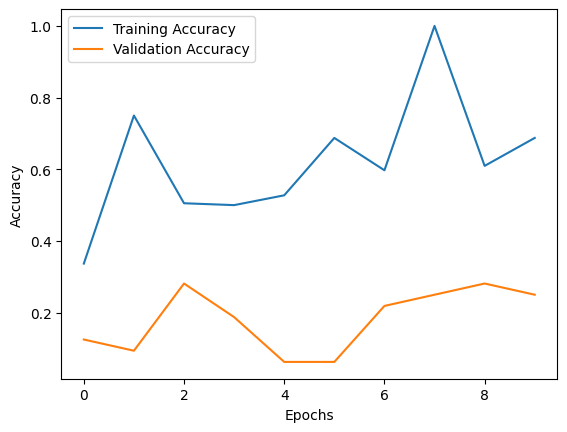

In [32]:
# Training Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

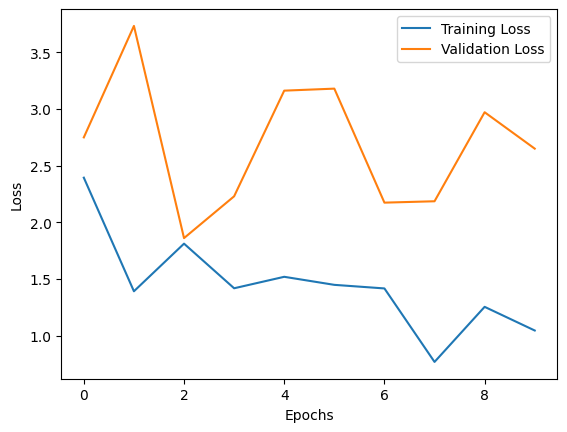

In [33]:
# Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
# Save model
model.save('models/model.h5')
model.save_weights('models/model.weights.h5')

## 5. Predict

In [35]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [36]:
def predict_single_image(img_path):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class = train_generator.class_indices
    class_label = {v: k for k, v in predicted_class.items()}
    predicted_label = class_label[np.argmax(prediction)]
    
    print(f"Predicted Label: {predicted_label}")

In [37]:
predict_single_image('data/test/Ceplok/SC012.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label: Ceplok


## 5. Evaluate

In [38]:
from sklearn.metrics import classification_report

In [39]:
Y_pred = model.predict(test_generator, test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 11s/step


In [40]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

Classification Report
              precision    recall  f1-score   support

      Ceplok       0.33      0.50      0.40        10
      Kawung       1.00      0.40      0.57        10
      Lereng       0.00      0.00      0.00        10
   Mix motif       0.00      0.00      0.00        10
       Nitik       0.56      1.00      0.71        10
      Parang       0.39      0.90      0.55        10

    accuracy                           0.47        60
   macro avg       0.38      0.47      0.37        60
weighted avg       0.38      0.47      0.37        60



c:\Users\Arleen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Arleen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Arleen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera